In [51]:
arrow::read_parquet(here("data", "atpTrans.parquet")) -> atp
atp %>% glimpse()

Rows: 682,069
Columns: 27
$ winner.name            <chr> "Patrick Rafter", "Dennis Van Scheppingen", "Ja…
$ winner.id              <chr> "r255", "s559", "s381", "d214", "r255", "s559",…
$ winner.rank            <int> 6, 126, 26, 85, 6, 126, 26, 11, 85, 6, 12, 55, …
$ winner.bornAt          <chr> "Australia", "Netherlands", "Netherlands", "Cze…
$ winner.domHand         <chr> "Right-Handed", "Right-Handed", "Left-Handed", …
$ winner.backHand        <chr> "One-Handed Backhand", "Unknown Backhand", "Unk…
$ winner.height          <int> 185, 185, 183, 188, 185, 185, 183, 185, 188, 18…
$ looser.name            <chr> "Martin Damm", "Richard Krajicek", "Steve Campb…
$ looser.id              <chr> "d214", "k214", "c355", "k237", "s572", "w254",…
$ looser.rank            <int> 85, 12, 95, 11, 55, 189, 58, 60, 100, 94, 42, 3…
$ looser.bornAt          <chr> "Czech Republic", "Netherlands", "USA", "Czech …
$ looser.domHand         <chr> "Right-Handed", "Right-Handed", "Right-Handed",…
$ looser.backH

FullTrans vai ser as transformações apó o filtro de Australia

In [52]:
atp %>% filter(tournament.location == "Australia") -> atpA

filter: removed 660,681 rows (97%), 21,388 rows remaining



In [53]:
# parquet doesn't seem to save factor
atpA %>% mutate(
    winner.backHand = winner.backHand             %>% as.factor,
    winner.domHand  = winner.domHand              %>% as.factor,
    looser.backHand = looser.backHand             %>% as.factor,
    looser.domHand  = looser.domHand              %>% as.factor,
    match.tournamentRound = match.tournamentRound %>% as.factor,
    tournament.ground = tournament.ground         %>% as.factor,
    tournament.location = tournament.location     %>% as.factor,
    winner.bornAt = winner.bornAt                 %>% as.factor,
    looser.bornAt = looser.bornAt                 %>% as.factor,
    match.setsCount = match.setsCount             %>% as.factor,
) -> atpAF

mutate: converted 'winner.bornAt' from character to factor (0 new NA)

        converted 'winner.domHand' from character to factor (0 new NA)

        converted 'winner.backHand' from character to factor (0 new NA)

        converted 'looser.bornAt' from character to factor (0 new NA)

        converted 'looser.domHand' from character to factor (0 new NA)

        converted 'looser.backHand' from character to factor (0 new NA)

        converted 'match.tournamentRound' from character to factor (0 new NA)

        converted 'match.setsCount' from integer to factor (0 new NA)

        converted 'tournament.ground' from character to factor (0 new NA)

        converted 'tournament.location' from character to factor (0 new NA)



In [54]:
if (FALSE) {
    atpAF %>% SmartEDA::ExpReport(op_file = "temp.html")
}

In [55]:
(atpAF %>% nrow() -> nmatches.inicial)

[1] 21388

In [56]:
# things to fix:
# turn nas into a factor too in backhand and domHand (backhand already has an unkown)
# fazer eda do rank para perceber como tratalos

# Prize

In [57]:
atpAF %>% 
    select(tournament.prize) %>%
    filter(str_detect(tournament.prize, fixed("$"), negate=T))

select: dropped 26 variables (winner.name, winner.id, winner.rank, winner.bornAt, winner.domHand, …)

filter: removed all rows (100%)



tournament.prize
<chr>


Isto significa que não há prémios sem $

In [58]:
atpAF %>%
    mutate(tp = str_remove_all(tournament.prize, r"{[,\$]}")) %>%
    filter(str_detect(tp, r"{[^0-9]}")) %>% 
    select(tp) %>% head(5)

mutate: new variable 'tp' (character) with 119 unique values and 1% NA

filter: removed 17,806 rows (83%), 3,582 rows remaining

select: dropped 27 variables (winner.name, winner.id, winner.rank, winner.bornAt, winner.domHand, …)



tp
<chr>
A9609870
A9609870
A9609870
A9609870
A9609870


Isto significa que há prémios em dollars Australianos

In [59]:
atpAF %>%
    mutate(tp = str_remove_all(tournament.prize, r"{[,\$A]}")) %>%
    filter(str_detect(tp, r"{[^0-9]}")) %>% 
    select(tp)

mutate: new variable 'tp' (character) with 119 unique values and 1% NA

filter: removed all rows (100%)

select: dropped 27 variables (winner.name, winner.id, winner.rank, winner.bornAt, winner.domHand, …)



tp
<chr>


Isto significa que não há outras moedas, apenas USD e AUD

In [60]:
doll_to_aus <- \(x) x*1.48
atpAF %>%
    rename(tp = tournament.prize) %>% 
    mutate(tournament.prize = case_when(
        tp %>% is.na()                 ~ NA,
        tp %>% str_detect(fixed("A$")) ~ tp %>% str_remove_all(r"{[\A$,]}") %>% as.double(),
        tp %>% str_detect(fixed("$"))  ~ tp %>% str_remove_all(r"{[\$,]}")  %>% as.double() %>% doll_to_aus(),
        TRUE ~ 9e+9
     )) %>% select(-tp) -> atpAFP
atpAFP %>% filter(tournament.prize == 9e+9) %>% nrow()

rename: renamed one variable (tp)

Warning message:
"There was 1 warning in `.fun()`.
ℹ In argument: `tournament.prize = case_when(...)`.
Caused by warning in `doll_to_aus()`:
! NAs introduced by coercion"
mutate: new variable 'tournament.prize' (double) with 119 unique values and 1% NA

select: dropped one variable (tp)

filter: removed all rows (100%)



[1] 0

# Alturas

In [61]:
library(skimr)
# atpAFP %>% skim(winner.height, looser.height) # yields error because of jup

Há muitos NAs e há números imposivelmente baixos

In [62]:
atpAFP %>% filter(winner.height %>% is.na) %>% select(player = winner.name, id = winner.id) -> a
atpAFP %>% filter(looser.height %>% is.na) %>% select(player = looser.name, id = looser.id) -> b
bind_rows(a, b) %>% distinct(player, id) -> c
print(nrow(c))
print(c %>% filter(id %>% is.na) %>% nrow())

filter: removed 18,204 rows (85%), 3,184 rows remaining

select: renamed 2 variables (player, id) and dropped 25 variables

filter: removed 16,386 rows (77%), 5,002 rows remaining

select: renamed 2 variables (player, id) and dropped 25 variables

distinct: removed 7,103 rows (87%), 1,083 rows remaining



[1] 1083


filter: removed 449 rows (41%), 634 rows remaining



[1] 634


1083 jogadores não têm a sua altura marcada, 634 desses porque os seus jogos não são analisados do seu ponto de vista na base de dados. Desta forma estes não vão ser considerados. Da mesma forma os jogadores com 0 de altura também não vão ser considerados. Estes podiam ser interpolados, mas neste contexto não faria sentido.

In [63]:
atpAFP %>% mutate(
    winner.height = ifelse(winner.height == 0, NA, winner.height), 
    looser.height = ifelse(looser.height == 0, NA, looser.height),
) %>% filter(!is.na(winner.height) & !is.na(looser.height)) -> atpAFPH

mutate: changed 128 values (1%) of 'winner.height' (128 new NA)

        changed 100 values (<1%) of 'looser.height' (100 new NA)

filter: removed 7,031 rows (33%), 14,357 rows remaining



In [64]:
atpAFPH %>% filter(winner.height < 160) %>% select(player = winner.name, id = winner.id, height = winner.height) -> a
atpAFPH %>% filter(looser.height < 160) %>% select(player = looser.name, id = looser.id, height = looser.height) -> b
bind_rows(a, b) %>% distinct(player, id, height)

filter: removed 14,315 rows (>99%), 42 rows remaining

select: renamed 3 variables (player, id, height) and dropped 24 variables

filter: removed 14,321 rows (>99%), 36 rows remaining

select: renamed 3 variables (player, id, height) and dropped 24 variables

distinct: removed 76 rows (97%), 2 rows remaining



player,id,height
<chr>,<chr>,<int>
Grant Stafford,s406,15
Nathan Healey,h431,15


Os únicos jogadores com alturas não realistas são os anteriores. Ao fazer uma pesquisa, não é claro porque estes estão mal anotados, mas:

* Nathan Healey  -> 180 cm
* Grant Stafford -> 188 cm

In [65]:
atpAFPHF <- atpAFPH %>% mutate(winner.height = case_when(
    winner.id == "h431" ~ 180,
    winner.id == "s406" ~ 188,
    TRUE ~ winner.height
), looser.height = case_when(
    looser.id == "h431" ~ 180,
    looser.id == "s406" ~ 188,
    TRUE ~ looser.height
))
# atpAFPHF %>% skim(winner.height, looser.height)

mutate: converted 'winner.height' from integer to double (0 new NA)

        converted 'looser.height' from integer to double (0 new NA)



# Jogos inválidos
De forma a facilitar a previsão, mas tirar jogos que acabaram prematuramente, or que não foram jogados. 

In [66]:
atpAFPHFR <- atpAFPHF %>% 
    filter(!match.wasRet, !match.wasWalkover, !match.wasDef) %>%
    select(-match.wasRet, -match.wasWalkover, -match.wasDef)
# atpAFPHFR %>% select(starts_with("match")) %>% skim()

filter: removed 437 rows (3%), 13,920 rows remaining

select: dropped 3 variables (match.wasRet, match.wasWalkover, match.wasDef)



Instruções superiores indicaram também que não vão ser analisados torneiros que incluém jogos à melhor de 5.

In [67]:
atpAFPHFR -> atp.wbo5
atp.wbo5 %>% 
    group_by(tournament.name) %>% 
    filter(!any(match.setsCount %>% as.integer > 3)) %>%
    ungroup() -> atp.wo45

group_by: one grouping variable (tournament.name)

filter (grouped): removed 7,073 rows (51%), 6,847 rows remaining

ungroup: no grouping variables



Jogos à melhor de 3 podem ter entre 3, 4 ou 5 sets, e jogos à melhor de 2 podem ter entre 2 e 3 sets. Logo, torneios que apenas tiveram jogos com 3 sets não são claros se são há melhor de 5.

In [68]:
atp.wo45 %>% 
    group_by(tournament.name) %>% 
    filter(all(match.setsCount == 3)) %>% 
    summarise()

group_by: one grouping variable (tournament.name)

filter (grouped): removed 6,835 rows (>99%), 12 rows remaining

summarise: now 5 rows and one column, ungrouped



tournament.name
<chr>
AUS v. MAR WG PO
AUS v. SWE WG 1st RD
AUS vs. SVK WG Play-Off
Adelaide-2
ROM V AUS QF


Felizmente apenas sobraram 5 desses torneios, portanto podemos pesquisar sobre estes manualmente

In [69]:
toRem = c("AUS v. MAR WG PO","AUS v. SWE WG 1st RD","AUS vs. SVK WG Play-Off","ROM V AUS QF")
atp.wo45 %>% filter(!(tournament.name %in% toRem)) -> atp.wobo5

filter: removed 8 rows (<1%), 6,839 rows remaining



In [70]:
atp.wobo5 %>% nrow()

[1] 6839

# domHand, backHand e rank

In [71]:
# atp.wobo5 %>% skim(winner.domHand, looser.domHand, winner.backHand,looser.backHand, winner.rank, looser.rank)

A base de dados inclui apenas 5 `missings` e 1 ambidestro. Como são poucos, podemos tirar estes. O mesmo se aplica ao rank de alguns jogos.

In [72]:
df <- atp.wobo5 %>% 
    filter(!(looser.domHand %>% is.na) & looser.domHand != "Ambidextrous") %>%
    filter(!(looser.rank %>% is.na) & !(winner.rank %>% is.na))
# df %>% skim(winner.domHand, looser.domHand, winner.backHand,looser.backHand)

filter: removed 6 rows (<1%), 6,833 rows remaining

filter: removed 468 rows (7%), 6,365 rows remaining



# Algumas características diretas

In [73]:
firstT <- df %>% arrange(tournament.date_start) %>% head(1) |> _$tournament.date_start
firstT 

[1] "1974-12-09"

In [74]:
df %>%
    unite("match.domHands", c(winner.domHand, looser.domHand)) %>%
    unite("match.backHands", c(winner.backHand, looser.backHand)) %>%
    mutate(
        match.domHands          = match.domHands %>% as.factor(),
        match.backHands         = match.backHands %>% as.factor(),
        match.diffHeights       = winner.height - looser.height,
        match.avgHeights        = rowMeans(across(c(winner.height, looser.height))),
        tournament.month        = month(tournament.date_start, label=T),
        tournament.quarter      = quarter(tournament.date_start) %>% as.factor(),
        tournament.dateDistance = difftime(firstT, tournament.date_start, units = "weeks"),
        match.diffRank          = winner.rank - looser.rank,
        match.avgRank           = rowMeans(across(c(winner.rank, looser.rank)))
    ) %>% 
    select(-tournament.location) %>% 
    mutate(match.setsCount = fct_drop(match.setsCount))->  dfF
# dfF %>% skim()

mutate: converted 'match.domHands' from character to factor (0 new NA)

        converted 'match.backHands' from character to factor (0 new NA)

        new variable 'match.diffHeights' (double) with 48 unique values and 0% NA

        new variable 'match.avgHeights' (double) with 51 unique values and 0% NA

        new variable 'tournament.month' (ordered factor) with 11 unique values and 0% NA

        new variable 'tournament.quarter' (factor) with 4 unique values and 0% NA

        new variable 'tournament.dateDistance' (double) with 360 unique values and 0% NA

        new variable 'match.diffRank' (integer) with 1,566 unique values and 0% NA

        new variable 'match.avgRank' (double) with 1,979 unique values and 0% NA

select: dropped one variable (tournament.location)

mutate: changed 0 values (0%) of 'match.setsCount' (0 new NA)



In [75]:
dfF %>% nrow()

[1] 6365

In [76]:
dfF %>% arrow::write_parquet(here("data", "featureless.parquet"))

# Primeiro modelo

mutate: converted 'match.setsCount' from factor to double (0 new NA)

select: dropped 24 variables (winner.name, winner.id, winner.rank, winner.bornAt, match.domHands, …)



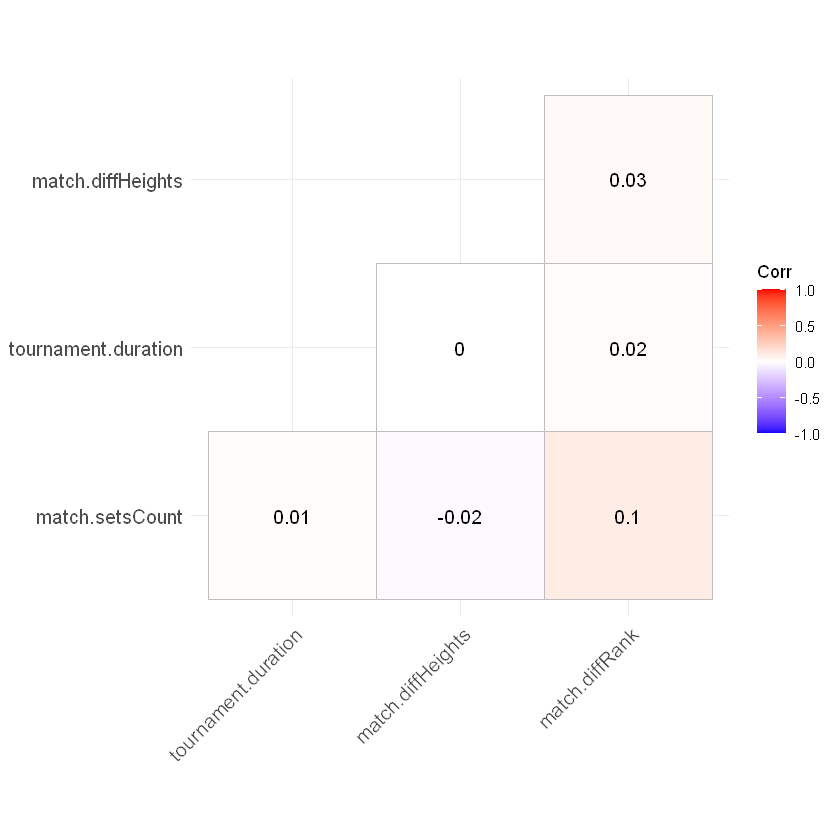

In [77]:
library(ggcorrplot)
cor(dfF %>% mutate(match.setsCount = match.setsCount %>% as.numeric) %>% select(
    match.setsCount,
    # tournament.dateDistance,
    # match.domHands,
    # match.backHands,
    # match.tournamentRound,
    # tournament.ground,
    # tournament.quarter,
    # match.hadTieBreaker,
    tournament.duration,
    match.diffHeights,
    match.diffRank
)) %>% ggcorrplot(type = "lower",lab = TRUE)

In [78]:
library(corrr)
dfF %>% select(
    match.setsCount,
    # tournament.dateDistance,
    match.domHands,
    match.backHands,
    match.tournamentRound,
    tournament.ground,
    tournament.quarter,
    match.hadTieBreaker,
    # tournament.duration,
    # match.diffHeights,
    # match.diffRank
) %>% colpair_map(function(x, y) {table(x, y) %>% rcompanion::cramerV()}, .diagonal = TRUE) %>% 
    as_matrix() %>% 
    ggcorrplot(type = "lower",lab = TRUE)

ERROR: Error in library(package, pos = pos, lib.loc = lib.loc, character.only = TRUE, : there is no package called 'corrr'


In [ ]:
# spliting
set.seed(1)
df.split <- initial_split(dfF, prop = 3/4, strata = match.setsCount)
df.train <- training(df.split)
df.test  <- testing (df.split)

In [ ]:
# first model
models.first <- workflow() %>% 
    add_model(logistic_reg(mode="classification")) %>%
    add_formula(match.setsCount ~ 
        tournament.dateDistance + 
        match.domHands + 
        match.backHands + 
        match.tournamentRound + 
        tournament.ground + 
        tournament.quarter + 
        match.hadTieBreaker + 
        tournament.duration + 
        match.diffHeights + 
        match.diffRank,
    ) %>% fit(df.train) # fit_resamples(df.10fold)
models.first %>% glance()

null.deviance,df.null,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
6099.459,4772,-2910.795,5887.589,6101.124,5821.589,4740,4773


In [ ]:
models.first.pred <- predict(models.first, df.test)
models.first.vs <- cbind(pred = models.first.pred, truth = df.test$match.setsCount) %>% rename(pred = .pred_class)
models.first.vs 

pred,truth
<fct>,<fct>
2,2
2,3
2,2
3,3
2,3
2,2
2,2
2,2
2,3


In [ ]:
models.first.vs %>% accuracy(truth= truth, estimate = pred)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.673995


In [ ]:
models.first.vs %>% f_meas(truth= truth, estimate = pred)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
f_meas,binary,0.7831174


In [ ]:
models.first.vs %>% conf_mat(truth= truth, estimate = pred)

          Truth
Prediction   2   3
         2 937 400
         3 119 136